
# AIRLINE PASSENGER (TIME SERIES) PREDICTION USING LSTM

 We will use Airline Passenger dataset for this project. This dataset provides monthly totals of a US airline passengers from 1949 to 1960. You can download the dataset from Kaggle link below: 
 https://www.kaggle.com/chirag19/air-passengers
 
 We will use LSTM deep learning model for this project. The Long Short-Term Memory network, or LSTM network, is a recurrent neural network that is trained using Backpropagation through time and overcomes the vanishing gradient problem. LSTM can be used to create large recurrent networks that in turn can be used to address difficult sequence problems in machine learning and achieve state-of-the-art results. Instead of neurons, LSTM networks have memory blocks that are connected through layers.

#### Aim of the project:
 
 Given the number of passengers (in units of thousands) for last two months, what is the number of passengers next month? In order to solve this problem we will build a LSTM model and train this model with our train data which is first 100 months in our dataset. After the LSTM model training finishes and learn the pattern in time series train data, we will ask it the above question  question and get the answer from it.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Dense,LSTM  # I use keras over Tensorflow 2, so I don't need extra Keras libraries.
from tensorflow.keras.models import Sequential  # Tensorflow includes Keras libraries after 2nd version of Tensorflow
from sklearn.preprocessing import MinMaxScaler  # If you have Tensorflow 1, please upgrade your library using:
                                                # conda install tensorflow
                                                # This command will upgrade your Tensorflow module to the latest version.

In [3]:
# You can downlad the dataset from Kaggle link below:
# https://www.kaggle.com/chirag19/air-passengers

data = pd.read_csv('AirPassengers.csv')
data.head()

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [4]:
data.rename(columns={'#Passengers':'passengers'},inplace=True)
# Since this is a time series, we need only second column.. So data now contains only passenger count...
data = data['passengers']

In [5]:
type(data)

pandas.core.series.Series

In [7]:
data

0      112
1      118
2      132
3      129
4      121
      ... 
139    606
140    508
141    461
142    390
143    432
Name: passengers, Length: 144, dtype: int64

My data fromat is Series, but I need 2D array for MinMaxScaler() and my other methods to work. 
So I will change to numpy array and reshape it.

In [8]:
data=np.array(data).reshape(-1,1)

In [9]:
# ok, now we have 2D numpy array...
type(data)

numpy.ndarray

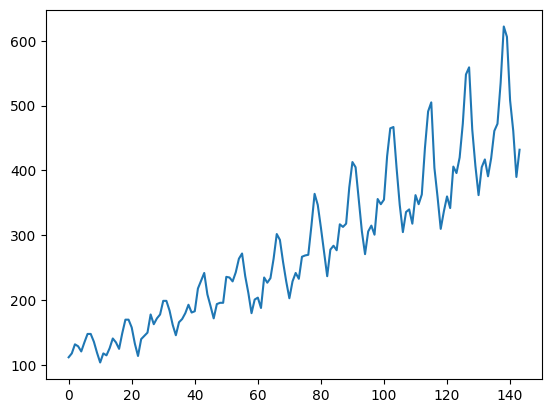

In [10]:
# Lets plot our data:
plt.plot(data)
plt.show()

### Scaling..

LSTM is sensitive to the scale of the input data. So we will rescale the data to the range of 0-to-1, also called normalizing

In [11]:
scaler = MinMaxScaler()
data = scaler.fit_transform(data)

### Train, Test split

In [12]:
len(data)

144

I have 144 data. I will use 100 of it as train set and 44 as test set..

In [13]:
train = data[0:100,:]
test = data[100:,:]

We will now define a function to prepare the train and test datasets for modeling. The function takes two arguments: the dataset, which is a NumPy array that we want to convert into a dataset, and the steps, which is the number of previous time steps to use as input variables to predict the next time period.

In [14]:
def get_data(data, steps):      
    dataX = []
    dataY = []
    for i in range(len(data)-steps-1):
        a = data[i:(i+steps), 0]
        dataX.append(a)
        dataY.append(data[i+steps, 0])
    return np.array(dataX), np.array(dataY)

#so since we give steps 2 here, it progresses in 3 steps by doing 2 training and 1 guess, this code actually makes it happen.

So using this "get_data" function I will prepare a dataset for modeling... Then I give this new prepared datset to my model for training...

In [15]:
steps = 2


### Now I'm making my datasets for both training and testing..

Important: You must have numpy version 1.19 in your Anaconda environment for LSTM work. If you have a error like "NotImplementedError: Cannot convert a symbolic Tensor (lstm/strided_slice:0) to a numpy array." you must change your numpy version to 1.19 using this commnad: 
 conda install numpy=1.19

In [16]:
X_train, y_train = get_data(train, steps)
X_test, y_test = get_data(test, steps)


In [17]:
# Im reshaping my sets for using in LSTM model..
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [19]:
import warnings
warnings.filterwarnings('ignore')


# I will use a Sequential model with 2 hidden layers
# Instead of neurons, LSTM networks have memory blocks that are connected through layers.
# The default sigmoid activation function is used for the LSTM blocks. 

model = Sequential()
model.add(LSTM(128, input_shape = (1, steps)))  # This is my first hidden layer with 128 memory blocks
model.add(Dense(64))                                  # This is my second hidden layer with 64 memory blocks
model.add(Dense(1))   # This is my output layer
model.compile(loss = 'mean_squared_error', optimizer = 'adam')

In [20]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                        │ (None, 128)                 │          67,072 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 75,393 (294.50 KB)

 Trainable params: 75,393 (294.50 KB)

 Non-trainable params: 0 (0.00 B)

### Now it's time to train our model...

In [21]:
model.fit(X_train, y_train, epochs=25, batch_size=1)

Epoch 1/25
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 796us/step - loss: 0.0150
Epoch 2/25
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step - loss: 0.0043  
Epoch 3/25
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step - loss: 0.0032
Epoch 4/25
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step - loss: 0.0026
Epoch 5/25
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 740us/step - loss: 0.0029  
Epoch 6/25
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step - loss: 0.0028
Epoch 7/25
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step - loss: 0.0031
Epoch 8/25
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step - loss: 0.0023  
Epoch 9/25
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step - loss: 0.0039
Epoch 10/25
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 784us/step - loss: 0.0029  
Epoch 11/25
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step - loss: 0.0032  
Epoch 12/25
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step - loss: 0.0031
Epoch 13/25
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step - loss: 0.0024  
Epoch 14/25
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step - loss: 0.0026  
Epoch 15/25
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 7

### Let's make prediction..

In [22]:
y_pred = model.predict(X_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


We should rescale the prediction results, because our model gives us scaled predictions..

In [23]:
y_pred = scaler.inverse_transform(y_pred)
y_test = y_test.reshape(-1, 1)
y_test = scaler.inverse_transform(y_test)

### Now plot the test set results... Remember our test set contains last 44 data in original dataset..

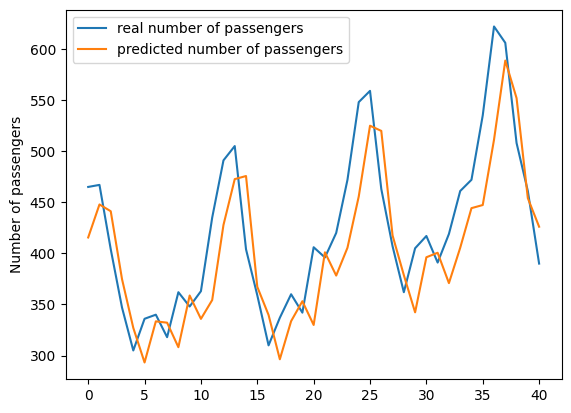

In [24]:
# plot real number of passengers and predictions...
plt.plot(y_test, label = 'real number of passengers')
plt.plot(y_pred, label = 'predicted number of passengers')
plt.ylabel('Months')
plt.ylabel('Number of passengers')
plt.legend()
plt.show()